<a href="https://colab.research.google.com/github/craigybaeb/msc-car-gan/blob/main/WGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# WGAN-GP overriding `Model.train_step`

**Author:** Craig Pirie <br>
**Date created:** 1/7/21<br>
**Last modified:** 1/7/21<br>
**Description:** Implementation of Wasserstein GAN with Gradient Penalty.

## Wasserstein GAN (WGAN) with Gradient Penalty (GP)

The original [Wasserstein GAN](https://arxiv.org/abs/1701.07875) leverages the
Wasserstein distance to produce a value function that has better theoretical
properties than the value function used in the original GAN paper. WGAN requires
that the discriminator (aka the critic) lie within the space of 1-Lipschitz
functions. The authors proposed the idea of weight clipping to achieve this
constraint. Though weight clipping works, it can be a problematic way to enforce
1-Lipschitz constraint and can cause undesirable behavior, e.g. a very deep WGAN
discriminator (critic) often fails to converge.

The [WGAN-GP](https://arxiv.org/pdf/1704.00028.pdf) method proposes an
alternative to weight clipping to ensure smooth training. Instead of clipping
the weights, the authors proposed a "gradient penalty" by adding a loss term
that keeps the L2 norm of the discriminator gradients close to 1.


## Setup


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import os
import gdown
import tarfile
import cv2 as cv

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print('GPU device not found')
else:
  print("GPU found.")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
os.makedirs("cars_gan")
os.makedirs("cars")
os.makedirs("augmented")

url = "http://ai.stanford.edu/~jkrause/car196/car_ims.tgz"
output = "cars_gan/data.tgz"
gdown.download(url, output, quiet=False)

tar = tarfile.open(output, "r:gz")
tar.extractall("/content/cars/")
tar.close()

In [ ]:
#instantiate the ImageDataGenerator class
datagen = ImageDataGenerator(
        rotation_range=40,
        height_shift_range=0.2,
        width_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')
#loop over the data in batches and this automatically saves the images
i = 0
for batch in datagen.flow_from_directory('/content/cars', batch_size=12,target_size=(64,64),
                          save_to_dir='/content/augmented', save_format='jpg'):
    i += 1
    if i % 1000 == 0:
     print(str(i))

    if i == 16185:
      print("Finished augmentation. Dataset size: {size} images".format(size=i*12))
      break

## Prepare the Stanford Car dataset



In [ ]:
IMG_SHAPE = (64, 64, 3)
BATCH_SIZE = 128

# Size of the noise vector
noise_dim = 128

dataset = keras.preprocessing.image_dataset_from_directory(
    "/content/augmented/", label_mode=None, image_size=(64, 64), batch_size=32
)
dataset = dataset.map(lambda x: (x - 127.5) / 127.5)

## Create the discriminator (the critic in the original WGAN)


In [ ]:

def conv_block(
    x,
    filters,
    activation,
    kernel_size=(3, 3),
    strides=(1, 1),
    padding="same",
    use_bias=True,
    use_bn=False,
    use_dropout=False,
    drop_value=0.5,
):
    x = layers.Conv2D(
        filters, kernel_size, strides=strides, padding=padding, use_bias=use_bias
    )(x)
    if use_bn:
        x = layers.BatchNormalization()(x)
    x = activation(x)
    if use_dropout:
        x = layers.Dropout(drop_value)(x)
    return x


def get_discriminator_model():
    img_input = layers.Input(shape=IMG_SHAPE)
    x = conv_block(
        img_input,
        64,
        kernel_size=(5, 5),
        strides=(2, 2),
        use_bn=False,
        use_bias=True,
        activation=layers.LeakyReLU(0.2),
        use_dropout=False,
        drop_value=0.3,
    )
    x = conv_block(
        x,
        128,
        kernel_size=(5, 5),
        strides=(2, 2),
        use_bn=False,
        activation=layers.LeakyReLU(0.2),
        use_bias=True,
        use_dropout=True,
        drop_value=0.3,
    )
    x = conv_block(
        x,
        256,
        kernel_size=(5, 5),
        strides=(2, 2),
        use_bn=False,
        activation=layers.LeakyReLU(0.2),
        use_bias=True,
        use_dropout=True,
        drop_value=0.3,
    )
    x = conv_block(
        x,
        512,
        kernel_size=(5, 5),
        strides=(2, 2),
        use_bn=False,
        activation=layers.LeakyReLU(0.2),
        use_bias=True,
        use_dropout=False,
        drop_value=0.3,
    )

    x = conv_block(
        x,
        1024,
        kernel_size=(5, 5),
        strides=(2, 2),
        use_bn=False,
        activation=layers.LeakyReLU(0.2),
        use_bias=True,
        use_dropout=False,
        drop_value=0.3,
    )

    x = layers.Flatten()(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(1)(x)

    d_model = keras.models.Model(img_input, x, name="discriminator")
    return d_model


d_model = get_discriminator_model()
d_model.summary()


Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 32, 32, 64)        4864      
_________________________________________________________________
leaky_re_lu_13 (LeakyReLU)   (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 16, 16, 128)       204928    
_________________________________________________________________
leaky_re_lu_14 (LeakyReLU)   (None, 16, 16, 128)       0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 8, 8, 256)       

## Create the generator


In [ ]:

def upsample_block(
    x,
    filters,
    activation,
    kernel_size=(3, 3),
    strides=(1, 1),
    up_size=(2, 2),
    padding="same",
    use_bn=False,
    use_bias=True,
    use_dropout=False,
    drop_value=0.3,
):
    x = layers.UpSampling2D(up_size)(x)
    x = layers.Conv2D(
        filters, kernel_size, strides=strides, padding=padding, use_bias=use_bias
    )(x)

    if use_bn:
        x = layers.BatchNormalization()(x)

    if activation:
        x = activation(x)
    if use_dropout:
        x = layers.Dropout(drop_value)(x)
    return x


def get_generator_model():
    noise = layers.Input(shape=(noise_dim,))
    x = layers.Dense(2 * 2 * 1024, use_bias=False)(noise)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)

    x = layers.Reshape((2, 2, 1024))(x)
    x = upsample_block(
        x,
        512,
        layers.LeakyReLU(0.2),
        strides=(1, 1),
        use_bias=False,
        use_bn=True,
        padding="same",
        use_dropout=False,
    )
    x = upsample_block(
        x,
        256,
        layers.LeakyReLU(0.2),
        strides=(1, 1),
        use_bias=False,
        use_bn=True,
        padding="same",
        use_dropout=False,
    )
    x = upsample_block(
        x,
        128,
        layers.LeakyReLU(0.2),
        strides=(1, 1),
        use_bias=False,
        use_bn=True,
        padding="same",
        use_dropout=False,
    )

    x = upsample_block(
        x,
        64,
        layers.LeakyReLU(0.2),
        strides=(1, 1),
        use_bias=False,
        use_bn=True,
        padding="same",
        use_dropout=False,
    )
    x = upsample_block(
        x, 3, layers.Activation("tanh"), strides=(1, 1), use_bias=False, use_bn=True
    )

    g_model = keras.models.Model(noise, x, name="generator")
    return g_model


g_model = get_generator_model()
g_model.summary()


Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 128)]             0         
_________________________________________________________________
dense_7 (Dense)              (None, 4096)              524288    
_________________________________________________________________
batch_normalization_17 (Batc (None, 4096)              16384     
_________________________________________________________________
leaky_re_lu_28 (LeakyReLU)   (None, 4096)              0         
_________________________________________________________________
reshape_4 (Reshape)          (None, 2, 2, 1024)        0         
_________________________________________________________________
up_sampling2d_13 (UpSampling (None, 4, 4, 1024)        0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 4, 4, 512)         47

## Create the WGAN-GP model

Now that we have defined our generator and discriminator, it's time to implement
the WGAN-GP model. We will also override the `train_step` for training.

In [ ]:
class WGAN(keras.Model):
    def __init__(
        self,
        discriminator,
        generator,
        latent_dim,
        discriminator_extra_steps=3,
        gp_weight=10.0,
    ):
        super(WGAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.d_steps = discriminator_extra_steps
        self.gp_weight = gp_weight

    def compile(self, d_optimizer, g_optimizer, d_loss_fn, g_loss_fn):
        super(WGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.d_loss_fn = d_loss_fn
        self.g_loss_fn = g_loss_fn

    def gradient_penalty(self, batch_size, real_images, fake_images):
        """ Calculates the gradient penalty.

        This loss is calculated on an interpolated image
        and added to the discriminator loss.
        """
        # Get the interpolated image
        alpha = tf.random.normal([batch_size, 1, 1, 1], 0.0, 1.0)
        diff = fake_images - real_images
        interpolated = real_images + alpha * diff

        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            # 1. Get the discriminator output for this interpolated image.
            pred = self.discriminator(interpolated, training=True)

        # 2. Calculate the gradients w.r.t to this interpolated image.
        grads = gp_tape.gradient(pred, [interpolated])[0]
        # 3. Calculate the norm of the gradients.
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
        gp = tf.reduce_mean((norm - 1.0) ** 2)
        return gp

    def train_step(self, real_images):
        if isinstance(real_images, tuple):
            real_images = real_images[0]

        # Get the batch size
        batch_size = tf.shape(real_images)[0]

        # For each batch, we are going to perform the
        # following steps as laid out in the original paper:
        # 1. Train the generator and get the generator loss
        # 2. Train the discriminator and get the discriminator loss
        # 3. Calculate the gradient penalty
        # 4. Multiply this gradient penalty with a constant weight factor
        # 5. Add the gradient penalty to the discriminator loss
        # 6. Return the generator and discriminator losses as a loss dictionary

        # Train the discriminator first. The original paper recommends training
        # the discriminator for `x` more steps (typically 5) as compared to
        # one step of the generator. Here we will train it for 3 extra steps
        # as compared to 5 to reduce the training time.
        for i in range(self.d_steps):
            # Get the latent vector
            random_latent_vectors = tf.random.normal(
                shape=(batch_size, self.latent_dim)
            )
            with tf.GradientTape() as tape:
                # Generate fake images from the latent vector
                fake_images = self.generator(random_latent_vectors, training=True)
                # Get the logits for the fake images
                fake_logits = self.discriminator(fake_images, training=True)
                # Get the logits for the real images
                real_logits = self.discriminator(real_images, training=True)

                # Calculate the discriminator loss using the fake and real image logits
                d_cost = self.d_loss_fn(real_img=real_logits, fake_img=fake_logits)
                # Calculate the gradient penalty
                gp = self.gradient_penalty(batch_size, real_images, fake_images)
                # Add the gradient penalty to the original discriminator loss
                d_loss = d_cost + gp * self.gp_weight

            # Get the gradients w.r.t the discriminator loss
            d_gradient = tape.gradient(d_loss, self.discriminator.trainable_variables)
            # Update the weights of the discriminator using the discriminator optimizer
            self.d_optimizer.apply_gradients(
                zip(d_gradient, self.discriminator.trainable_variables)
            )

        # Train the generator
        # Get the latent vector
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        with tf.GradientTape() as tape:
            # Generate fake images using the generator
            generated_images = self.generator(random_latent_vectors, training=True)
            # Get the discriminator logits for fake images
            gen_img_logits = self.discriminator(generated_images, training=True)
            # Calculate the generator loss
            g_loss = self.g_loss_fn(gen_img_logits)

        # Get the gradients w.r.t the generator loss
        gen_gradient = tape.gradient(g_loss, self.generator.trainable_variables)
        # Update the weights of the generator using the generator optimizer
        self.g_optimizer.apply_gradients(
            zip(gen_gradient, self.generator.trainable_variables)
        )
        return {"d_loss": d_loss, "g_loss": g_loss}

## Create a Keras callback that periodically saves generated images

In [ ]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=6, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images = (generated_images * 127.5) + 127.5

        for i in range(self.num_img):
            img = generated_images[i].numpy()
            img = keras.preprocessing.image.array_to_img(img)
            img.save("/content/drive/My Drive/Masters/AFTER_TEST/generated_img_{epoch}_{i}.png".format(i=i, epoch=epoch))



## Train the end-to-end model


## Default

In [ ]:
# Instantiate the optimizer for both networks
# (learning_rate=0.0002, beta_1=0.5 are recommended)
generator_optimizer = keras.optimizers.Adam(
    learning_rate=0.0002, beta_1=0.5, beta_2=0.9
)
discriminator_optimizer = keras.optimizers.Adam(
    learning_rate=0.0002, beta_1=0.5, beta_2=0.9
)

# Define the loss functions for the discriminator,
# which should be (fake_loss - real_loss).
# We will add the gradient penalty later to this loss function.
def discriminator_loss(real_img, fake_img):
    real_loss = tf.reduce_mean(real_img)
    fake_loss = tf.reduce_mean(fake_img)
    return fake_loss - real_loss


# Define the loss functions for the generator.
def generator_loss(fake_img):
    return -tf.reduce_mean(fake_img)


# Set the number of epochs for trainining.
epochs = 20

# Instantiate the customer `GANMonitor` Keras callback.
cbk = GANMonitor(num_img=10, latent_dim=noise_dim)

# Instantiate the WGAN model.
wgan = WGAN(
    discriminator=d_model,
    generator=g_model,
    latent_dim=noise_dim,
    discriminator_extra_steps=3,
)

# Compile the WGAN model.
wgan.compile(
    d_optimizer=discriminator_optimizer,
    g_optimizer=generator_optimizer,
    g_loss_fn=generator_loss,
    d_loss_fn=discriminator_loss,
)

# Start training the model.
wgan.fit(dataset, batch_size=BATCH_SIZE, epochs=epochs, callbacks=[cbk])

## Learning rate

Display the last generated images:


In [ ]:
# Instantiate the optimizer for both networks
# (learning_rate=0.0002, beta_1=0.5 are recommended)
generator_optimizer = keras.optimizers.Adam(
    learning_rate=0.0001, beta_1=0.5, beta_2=0.9
)
discriminator_optimizer = keras.optimizers.Adam(
    learning_rate=0.0001, beta_1=0.5, beta_2=0.9
)

# Define the loss functions for the discriminator,
# which should be (fake_loss - real_loss).
# We will add the gradient penalty later to this loss function.
def discriminator_loss(real_img, fake_img):
    real_loss = tf.reduce_mean(real_img)
    fake_loss = tf.reduce_mean(fake_img)
    return fake_loss - real_loss


# Define the loss functions for the generator.
def generator_loss(fake_img):
    return -tf.reduce_mean(fake_img)


# Set the number of epochs for trainining.
epochs = 20

# Instantiate the customer `GANMonitor` Keras callback.
cbk = GANMonitor(num_img=10, latent_dim=noise_dim)

# Instantiate the WGAN model.
wgan = WGAN(
    discriminator=d_model,
    generator=g_model,
    latent_dim=noise_dim,
    discriminator_extra_steps=3,
)

# Compile the WGAN model.
wgan.compile(
    d_optimizer=discriminator_optimizer,
    g_optimizer=generator_optimizer,
    g_loss_fn=generator_loss,
    d_loss_fn=discriminator_loss,
)

# Start training the model.
wgan.fit(dataset, batch_size=BATCH_SIZE, epochs=epochs, callbacks=[cbk])

## BETA

In [ ]:
# Instantiate the optimizer for both networks
# (learning_rate=0.0002, beta_1=0.5 are recommended)
generator_optimizer = keras.optimizers.Adam(
    learning_rate=0.0001, beta_1=0.3, beta_2=0.9
)
discriminator_optimizer = keras.optimizers.Adam(
    learning_rate=0.0001, beta_1=0.3, beta_2=0.9
)

# Define the loss functions for the discriminator,
# which should be (fake_loss - real_loss).
# We will add the gradient penalty later to this loss function.
def discriminator_loss(real_img, fake_img):
    real_loss = tf.reduce_mean(real_img)
    fake_loss = tf.reduce_mean(fake_img)
    return fake_loss - real_loss


# Define the loss functions for the generator.
def generator_loss(fake_img):
    return -tf.reduce_mean(fake_img)


# Set the number of epochs for trainining.
epochs = 20

# Instantiate the customer `GANMonitor` Keras callback.
cbk = GANMonitor(num_img=10, latent_dim=noise_dim)

# Instantiate the WGAN model.
wgan = WGAN(
    discriminator=d_model,
    generator=g_model,
    latent_dim=noise_dim,
    discriminator_extra_steps=3,
)

# Compile the WGAN model.
wgan.compile(
    d_optimizer=discriminator_optimizer,
    g_optimizer=generator_optimizer,
    g_loss_fn=generator_loss,
    d_loss_fn=discriminator_loss,
)

# Start training the model.
wgan.fit(dataset, batch_size=BATCH_SIZE, epochs=epochs, callbacks=[cbk])

## EXTRA STEPS

In [ ]:
# Instantiate the optimizer for both networks
# (learning_rate=0.0002, beta_1=0.5 are recommended)
generator_optimizer = keras.optimizers.Adam(
    learning_rate=0.0002, beta_1=0.5, beta_2=0.9
)
discriminator_optimizer = keras.optimizers.Adam(
    learning_rate=0.0002, beta_1=0.5, beta_2=0.9
)

# Define the loss functions for the discriminator,
# which should be (fake_loss - real_loss).
# We will add the gradient penalty later to this loss function.
def discriminator_loss(real_img, fake_img):
    real_loss = tf.reduce_mean(real_img)
    fake_loss = tf.reduce_mean(fake_img)
    return fake_loss - real_loss


# Define the loss functions for the generator.
def generator_loss(fake_img):
    return -tf.reduce_mean(fake_img)


# Set the number of epochs for trainining.
epochs = 20

# Instantiate the customer `GANMonitor` Keras callback.
cbk = GANMonitor(num_img=10, latent_dim=noise_dim)

# Instantiate the WGAN model.
wgan = WGAN(
    discriminator=d_model,
    generator=g_model,
    latent_dim=noise_dim,
    discriminator_extra_steps=5,
)

# Compile the WGAN model.
wgan.compile(
    d_optimizer=discriminator_optimizer,
    g_optimizer=generator_optimizer,
    g_loss_fn=generator_loss,
    d_loss_fn=discriminator_loss,
)

# Start training the model.
wgan.fit(dataset, batch_size=BATCH_SIZE, epochs=epochs, callbacks=[cbk])

# Evaluate

In [ ]:
from IPython.display import Image, display
!pip install pytorch-fid

In [ ]:
#Default
!python -m pytorch_fid '/content/augmented' '/content/drive/My Drive/Masters/WGAN_LAST'

tcmalloc: large alloc 3181559808 bytes == 0x55bf3d264000 @  0x7f71bccef1e7 0x7f71ba72f46e 0x7f71ba77fc7b 0x7f71ba78035f 0x7f71ba822103 0x55bec8b11010 0x55bec8b10da0 0x55bec8b852f9 0x55bec8b7fc35 0x55bec8b1273a 0x55bec8b80b0e 0x55bec8b7fc35 0x55bec8b1273a 0x55bec8b80b0e 0x55bec8b80235 0x55bec8b1273a 0x55bec8b80b0e 0x55bec8b1265a 0x55bec8b80b0e 0x55bec8b1265a 0x55bec8b84f40 0x55bec8b7fc35 0x55bec8b7f933 0x55bec8b7dda0 0x55bec8b10ea9 0x55bec8b10da0 0x55bec8b84bb3 0x55bec8b7fc35 0x55bec8b1273a 0x55bec8b80b0e 0x55bec8b7fc35
  0% 0/3884 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
100% 3884/3884 [07:43<00:00,  8.39it/s]
tcm

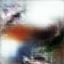

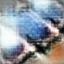

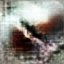

In [ ]:
display(Image('/content/drive/My Drive/Masters/WGAN_LAST/Copy of generated_img_19_0.png'))
display(Image('/content/drive/My Drive/Masters/WGAN_LAST/Copy of generated_img_19_1.png'))
display(Image('/content/drive/My Drive/Masters/WGAN_LAST/Copy of generated_img_19_2.png'))

In [ ]:
#Learning Rate
!python -m pytorch_fid '/content/augmented' '/content/drive/My Drive/Masters/WGAN_LAST_LR'

tcmalloc: large alloc 3181559808 bytes == 0x562bc142a000 @  0x7f043cd331e7 0x7f043a77346e 0x7f043a7c3c7b 0x7f043a7c435f 0x7f043a866103 0x562b4de2d010 0x562b4de2cda0 0x562b4dea12f9 0x562b4de9bc35 0x562b4de2e73a 0x562b4de9cb0e 0x562b4de9bc35 0x562b4de2e73a 0x562b4de9cb0e 0x562b4de9c235 0x562b4de2e73a 0x562b4de9cb0e 0x562b4de2e65a 0x562b4de9cb0e 0x562b4de2e65a 0x562b4dea0f40 0x562b4de9bc35 0x562b4de9b933 0x562b4de99da0 0x562b4de2cea9 0x562b4de2cda0 0x562b4dea0bb3 0x562b4de9bc35 0x562b4de2e73a 0x562b4de9cb0e 0x562b4de9bc35
  0% 0/3884 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
100% 3884/3884 [07:44<00:00,  8.36it/s]
tcm

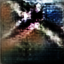

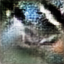

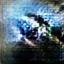

In [ ]:
display(Image('/content/drive/My Drive/Masters/WGAN_LAST_LR/Copy of generated_img_19_0.png'))
display(Image('/content/drive/My Drive/Masters/WGAN_LAST_LR/Copy of generated_img_19_1.png'))
display(Image('/content/drive/My Drive/Masters/WGAN_LAST_LR/Copy of generated_img_19_2.png'))

In [ ]:
#Extra
!python -m pytorch_fid '/content/augmented' '/content/drive/My Drive/Masters/WGAN_LAST_EXTRA'

tcmalloc: large alloc 3181559808 bytes == 0x55d16b6d2000 @  0x7fae8bf511e7 0x7fae8999146e 0x7fae899e1c7b 0x7fae899e235f 0x7fae89a84103 0x55d0f85c5010 0x55d0f85c4da0 0x55d0f86392f9 0x55d0f8633c35 0x55d0f85c673a 0x55d0f8634b0e 0x55d0f8633c35 0x55d0f85c673a 0x55d0f8634b0e 0x55d0f8634235 0x55d0f85c673a 0x55d0f8634b0e 0x55d0f85c665a 0x55d0f8634b0e 0x55d0f85c665a 0x55d0f8638f40 0x55d0f8633c35 0x55d0f8633933 0x55d0f8631da0 0x55d0f85c4ea9 0x55d0f85c4da0 0x55d0f8638bb3 0x55d0f8633c35 0x55d0f85c673a 0x55d0f8634b0e 0x55d0f8633c35
  0% 0/3884 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
100% 3884/3884 [07:43<00:00,  8.38it/s]
tcm

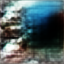

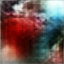

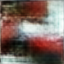

In [ ]:
display(Image('/content/drive/My Drive/Masters/WGAN_LAST_EXTRA/Copy of generated_img_19_0.png'))
display(Image('/content/drive/My Drive/Masters/WGAN_LAST_EXTRA/Copy of generated_img_19_1.png'))
display(Image('/content/drive/My Drive/Masters/WGAN_LAST_EXTRA/Copy of generated_img_19_2.png'))

In [ ]:
#Beta
!python -m pytorch_fid '/content/augmented' '/content/drive/My Drive/Masters/WGAN_LAST_BETA'

tcmalloc: large alloc 3181559808 bytes == 0x55cdab78e000 @  0x7f10d67f61e7 0x7f10d423646e 0x7f10d4286c7b 0x7f10d428735f 0x7f10d4329103 0x55cd36f93010 0x55cd36f92da0 0x55cd370072f9 0x55cd37001c35 0x55cd36f9473a 0x55cd37002b0e 0x55cd37001c35 0x55cd36f9473a 0x55cd37002b0e 0x55cd37002235 0x55cd36f9473a 0x55cd37002b0e 0x55cd36f9465a 0x55cd37002b0e 0x55cd36f9465a 0x55cd37006f40 0x55cd37001c35 0x55cd37001933 0x55cd36fffda0 0x55cd36f92ea9 0x55cd36f92da0 0x55cd37006bb3 0x55cd37001c35 0x55cd36f9473a 0x55cd37002b0e 0x55cd37001c35
  0% 0/3884 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
100% 3884/3884 [07:42<00:00,  8.40it/s]
tcm

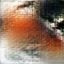

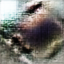

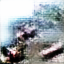

In [ ]:
display(Image('/content/drive/My Drive/Masters/WGAN_LAST_BETA/Copy of generated_img_19_0.png'))
display(Image('/content/drive/My Drive/Masters/WGAN_LAST_BETA/Copy of generated_img_19_1.png'))
display(Image('/content/drive/My Drive/Masters/WGAN_LAST_BETA/Copy of generated_img_19_2.png'))

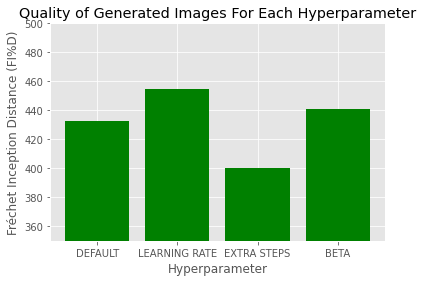

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

x = ['DEFAULT','LEARNING RATE','EXTRA STEPS','BETA']
FID = [432.7342636187919,454.616882104857,400.34296924322473,441.25052898792507]

x_pos = [i for i, _ in enumerate(x)]

plt.bar(x_pos, FID, color='green')
plt.xlabel("Hyperparameter")
plt.ylabel("Fréchet Inception Distance (FI%D)")
plt.title("Quality of Generated Images For Each Hyperparameter")

plt.xticks(x_pos, x)
axes = plt.gca()
axes.set_ylim([350,500])

plt.show()